In [1]:
import h5py
import numpy as np
import torch
import torch.utils.data as data
from scipy.io import savemat

from task_datasets.wv3 import WV3Datasets
from task_datasets.HISR import HISRDataSets
from model import build_network
from utils import AnalysisPanAcc, viz_batch, load_config, res_image

device = 'cuda:0'
path = '/Data2/DataSet/pansharpening/test1_mulExm1258.mat'
# path = '/Data2/DataSet/pansharpening_2/test_data/WV3/test_wv3_multiExm1.h5'
# path = '/Data2/DataSet/HISR/CAVE/test_cave(with_up)x4.h5'
dataset_type = 'wv3'
bs = 8

# model = VanillaPANNet(8, 32).to('cuda:0')

name = 'dcformer'
subarch = 'reduce'

if name in ['panformer', 'dcformer']:
    config = load_config(name)
    full_arch = name + '_' + subarch
    model = build_network(full_arch, **config['network_configs'][full_arch])
else:
    config = load_config(name)
    model = build_network(name, **config['network_configs'])

# ======================worldview3 checkpoint============
# p = './weight/pannet_3vskemk0.pth'  # pannet
# p = './weight/panformer_44v9p9t3.pth'  # gau
# p = './weight/panformer_1bxe3b0v.pth'  # restormer
# p = './weight/fusionnet_30zvejpu.pth'  # fusionnet
# p = './weight/dcformer_2t9tw637.pth'  # dcformer with attention grad
# p = './weight/dcformer_22vv4nzx.pth'  # dcformer sota
# p = './weight/dcformer_2vt2nluz.pth'  # dcformer_dpw without attention grad
# p = './weight/dcformer_1thsgpdv.pth'  # dcformer_dpw with partially switch qkv
# p = './weight/dcformer_3jhs05so.pth'  # dcformer_dpw with fully switch qkv
# p = './weight/dcformer_3vg8vlh9.pth'  # dcformer_dpw with only switch qkv in fuse layer, depth = [4, [4, 4], [4, 4, 4]] and another cross-attn in FPN between b1_in and b2_in(after CFSBlock)
# p = './weight/dcformer_2azisub2.pth'  # dcformer with less depth (all depth is 2)
# p = './weight/dcformer_3baebtne.pth'  # dcformer_dpw [4, [4, 3], [4, 3, 2]]
# p = './weight/dcformer_16hbiq2c.pth'  # dcformer_woo [4, [4, 3], [4, 3, 2]]
# p = './weight/dcformer_19e6v9x5.pth'  # dcformer_reduce
p = './weight/dcformer_o7woscjm.pth'  # dcfomer use avgpool
# p = './weight/dcformer_2enz0i9d.pth'  # dcformer dynamic kernel
# ========================================================

# ================HISI CAVE checkpoint=============
# p = './weight/dcformer_37xwviyh.pth'  # dcformer_reduce on HISI CAVE dataset
# =================================================

params = torch.load(p, map_location=device)
# odict = OrderedDict()
# for k, v in params['model'].items():
#    odict['module.' + k] = v
model.load_state_dict(params['model'])
model = model.to(device)
model.eval()

d = h5py.File(path)
if dataset_type == 'wv3':
    gt, ms, lms, pan = np.asarray(d['gt']), np.asarray(d['ms']), np.asarray(d['lms']), np.asarray(d['pan'])
    pan = pan[:, np.newaxis, ...]
    ms, lms, gt = map(lambda x: x.transpose([0, 3, 1, 2]), [ms, lms, gt])
    d = dict(gt=gt, ms=ms, lms=lms, pan=pan)
    ds = WV3Datasets(d, hp=False)
elif dataset_type == 'hisi':
    d = h5py.File(path)
    ds = HISRDataSets(d)
else:
    raise NotImplementedError
dl = data.DataLoader(ds, batch_size=bs, shuffle=True)
analysis = AnalysisPanAcc()


concat head
datasets shape:
        pan                  ms                 lms                  gt         
 (1258, 1, 64, 64)   (1258, 8, 16, 16)   (1258, 8, 64, 64)   (1258, 8, 64, 64)  


In [2]:
from model.module.attention import ReducedAttention

In [3]:
import torch.nn as nn

def hook_model(model: nn.Module, saved_tensor, hook_class):
    def feature_hook(m, input_x, output):
        # forward hook
        saved_tensor.append([input_x, output, m])

    hooks = []
    for n, m in model.named_modules():
        if isinstance(m, hook_class):
            hooks.append(m.register_forward_hook(feature_hook))
    return model, hooks

attns = []
model, hooks = hook_model(model, attns, ReducedAttention)

In [4]:
all_sr = []
with torch.no_grad():
    for i, (pan, ms, lms, gt) in enumerate(dl, 1):
        pan, ms, lms, gt = pan.to(device).float(), ms.to(device).float(), lms.to(device).float(), gt.to(device).float()

        sr = model.val_step(ms, lms, pan)
        sr1 = sr.detach().cpu().numpy()
        all_sr.append(sr1)

        analysis(gt, sr)

        res = res_image(gt, sr)
        break

In [3]:
import einops

def crop_inference(model,
                   xs,
                   crop_size = (16, 64, 64),
                   stride = (8, 32, 32)):
    # only support CAVE dataset
    # input shape: 128, 512, 512

    # xs: (hsi_lr, hsi_up, rgb)

    torch.backends.cudnn.enable = True
    torch.backends.cudnn.benchmark = True

    # preprocessing
    crop_xs = []
    ncols = []
    bs, out_c, _, _ = xs[0].shape
    _, _, out_h, out_w = xs[-1].shape
    for i in range(len(xs)):
        x = xs[i]
        _, c, h, _ = x.shape  # assume h equals w
        crop = crop_size[i]
        s = stride[i]

        ncol = (h - crop) // s
        ncols.append(ncol)
        crop_x = F.unfold(x, crop, stride=s)
        crop_x = einops.rearrange(crop_x, 'b (c k l) m -> m b c k l', k=crop, l=crop, c=c)
        crop_xs.append(crop_x)

    # model inference
    model.eval()
    out = []
    for i in range(crop_xs[0].size(0)):
        input = [crop_xs[j][i].cuda(0) for j in range(len(xs))]
        out.append(model.val_step(*input).detach().cpu())  # [bs * 225, 31, 64, 64]
        del input
        torch.cuda.empty_cache()
    # input: 255*[b, 31, 64, 64]
    out = torch.cat(out, dim=0)

    # postprocessing
    out = einops.rearrange(out, '(m b) c k l -> b (c k l) m', b=bs, k=crop_size[-1], l=crop_size[-1], c=out_c)
    output = F.fold(out, output_size=(out_h, out_w),
                    kernel_size=(crop_size[-1], crop_size[-1]),
                    dilation=1,
                    padding=0,
                    stride=(stride[-1], stride[-1]))

    # ncol = ncols[-1]
    # out = out.view(bs, -1, out_c, crop_size[-2], crop_size[-1])  # [bs, 225, 64, 64]
    # output = torch.zeros(bs, out_c, out_h, out_w)
    # for bi in range(bs):
    #     for i in range(ncol):
    #         for j in range(ncol):
    #             y = out[bi]  # [255, 64, 64]

    return output

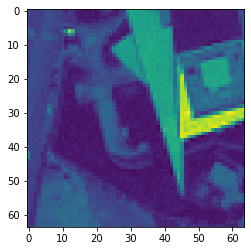

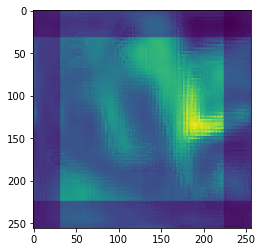

In [9]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

for pan, ms, lms, gt in dl:
    break

ms = F.interpolate(ms, scale_factor=4)
lms = F.interpolate(lms, scale_factor=4)
pan = F.interpolate(pan, scale_factor=4)

sr = crop_inference(model, [ms.float(), lms.float(), pan.float()])

plt.imshow(gt[0, 0].detach().cpu().numpy())
plt.show()

plt.imshow(sr[0].mean(0).detach().cpu().numpy())
plt.show()

In [ ]:
from torch.nn import functional as F
from einops import rearrange

def qk_relation_map(m, tgt, mem, pos=None):
    b, c, h, w = tgt.shape
    _, c, h2, w2 = mem.shape
    interp_mem = m.match_c(F.interpolate(mem, size=tgt.shape[-2:]))
    residual = m.reduce(tgt - interp_mem)

    q = m.q_dw(m.q(tgt))
    kv = m.kv_dw(m.kv(residual))
    k, v = kv.chunk(2, dim=1)

    # propagate residual information to tgt
    q = rearrange(q, 'b (head c) h w -> b head (h w) c', head=m.num_heads)
    k = rearrange(k, 'b (head c) h w -> b head (h w) c', head=m.num_heads)
    v = rearrange(v, 'b (head c) h w -> b head (h w) c', head=m.num_heads)
    
    q = torch.nn.functional.normalize(q, dim=-1)
    k = torch.nn.functional.normalize(k, dim=-1)
    attn = (q @ k.transpose(-2, -1)) * m.temperature  # [b, h, h1w1, h2w2]
    attn = attn.softmax(dim=-1)
    # print(q.shape, k.shape)
    
    # q, k relation
    # print(attn.shape)
    if pos is None:
        pos = attn.shape[-2] // 2
    relation = attn[..., pos, :]  # [b, head, h//4*w//4]
    # print(relation.shape)
    relation = relation.view(b, m.num_heads, h//4, w//4)
    
    return relation, attn


torch.Size([64, 64])


Text(0.5, 1.0, 'qk relation: (16, 16)')

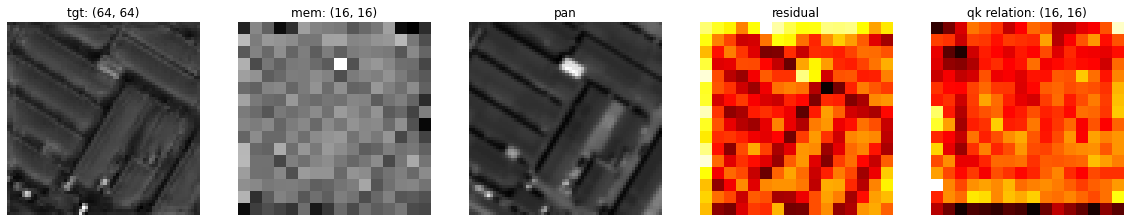

In [8]:
index = 4
sample_index = 2
head_index = 0

input_tgt = attns[index][0][0]
input_mem = attns[index][0][1]
output = attns[index][1]
m = attns[index][2]

mean_tgt = input_tgt.mean(1, keepdim=True)
mean_mem = F.interpolate(input_mem.mean(1, keepdim=True), size=mean_tgt.shape[-2:])

#====in module====
interp_mem = F.interpolate(input_mem, size=input_tgt.shape[-2:])
matched_interp_mem = m.match_c(interp_mem)
residual = m.reduce(input_tgt - matched_interp_mem)
#=================

import matplotlib.pyplot as plt

print(mean_tgt[index, 0].shape)
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(20, 50))

for ax in axes:
    ax.set_axis_off()
axes[0].imshow(mean_tgt[sample_index, 0].cpu().numpy(), 'gray')
axes[0].set_title(f'tgt: {tuple(input_tgt.shape[-2:])}')
axes[1].imshow(mean_mem[sample_index, 0].cpu().numpy(), 'gray')
axes[1].set_title(f'mem: {tuple(input_mem.shape[-2:])}')
axes[2].imshow(pan[sample_index, 0].cpu().numpy(), 'gray')
axes[2].set_title('pan')

axes[3].imshow(residual[sample_index].mean(0).detach().cpu().numpy(), 'hot')
axes[3].set_title('residual')

qk_relation, attn = qk_relation_map(m, input_tgt, input_mem)
axes[4].imshow(qk_relation.mean(0)[head_index, ...].detach().cpu().numpy(), 'hot')
axes[4].set_title(f'qk relation: {qk_relation.size(-2), qk_relation.size(-1)}')

# axes[5].imshow(attn[sample_index, head_index, ...].detach().cpu().numpy(), 'hot')
# axes[5].set_title(f'attn: {attn.size(-2), attn.size(-1)}')

In [227]:
r = np.random.randn(5, 5)
r_f = r.flatten()

r_f[18], r[3, 3]

(-1.3369908699990045, -1.3369908699990045)

In [219]:
attn.shape

torch.Size([8, 4, 1024, 64])

In [127]:
64*64*0.8+10

3286.8

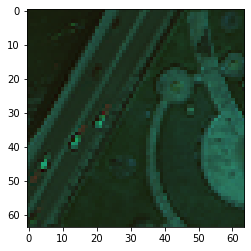

In [204]:
plt.imshow(gt[sample_index].cpu().numpy()[[0, 2, 4], ...].transpose([1, 2, 0]))

# 重新写入融合图片

In [5]:
import h5py
import numpy as np
import os
import os.path as osp
import scipy.io as io
from tqdm import tqdm


file = r'/Data2/ZiHanCao/exps/panformer/visualized_img/data_dcformermwsa_new_qb_ref.mat'

name = file.split('/')[-1].strip('.mat')
path = f'/Data2/ZiHanCao/exps/panformer/visualized_img/{name}'
print(path)
save_prefix = 'output_mulExm_'
if not osp.exists(path):
    os.mkdir(path)
    print(f'make dir {name}')

/Data2/ZiHanCao/exps/panformer/visualized_img/data_dcformermwsa_new_qb_ref


In [6]:
mat_file = io.loadmat(file)
print(f'has keys: {mat_file.keys()}')

sr = mat_file.get('sr')
if sr is None:
    print('has no key sr')
else:
    bar = tqdm(range(sr.shape[0]))
    for i in bar:
        save_path = osp.join(path, save_prefix+f'{i}.mat')
        sr_i = np.transpose(sr[i, ...], [1,2,0])
        save_d = {'sr': sr_i}
        io.savemat(save_path, save_d)
        bar.set_description(f'save {i}.mat')
        
        

has keys: dict_keys(['__header__', '__version__', '__globals__', 'sr', 'gt', 'ms', 'lms', 'pan'])


save 19.mat: 100%|██████████| 20/20 [00:01<00:00, 14.14it/s]


['/Data2/ZiHanCao/exps/panformer/visualized_img/data_hpmnet_qb_unref/output_mulExm_0.mat', '/Data2/ZiHanCao/exps/panformer/visualized_img/data_hpmnet_qb_unref/output_mulExm_1.mat', '/Data2/ZiHanCao/exps/panformer/visualized_img/data_hpmnet_qb_unref/output_mulExm_2.mat', '/Data2/ZiHanCao/exps/panformer/visualized_img/data_hpmnet_qb_unref/output_mulExm_3.mat', '/Data2/ZiHanCao/exps/panformer/visualized_img/data_hpmnet_qb_unref/output_mulExm_4.mat', '/Data2/ZiHanCao/exps/panformer/visualized_img/data_hpmnet_qb_unref/output_mulExm_5.mat', '/Data2/ZiHanCao/exps/panformer/visualized_img/data_hpmnet_qb_unref/output_mulExm_6.mat', '/Data2/ZiHanCao/exps/panformer/visualized_img/data_hpmnet_qb_unref/output_mulExm_7.mat', '/Data2/ZiHanCao/exps/panformer/visualized_img/data_hpmnet_qb_unref/output_mulExm_8.mat', '/Data2/ZiHanCao/exps/panformer/visualized_img/data_hpmnet_qb_unref/output_mulExm_9.mat', '/Data2/ZiHanCao/exps/panformer/visualized_img/data_hpmnet_qb_unref/output_mulExm_10.mat', '/Data2/

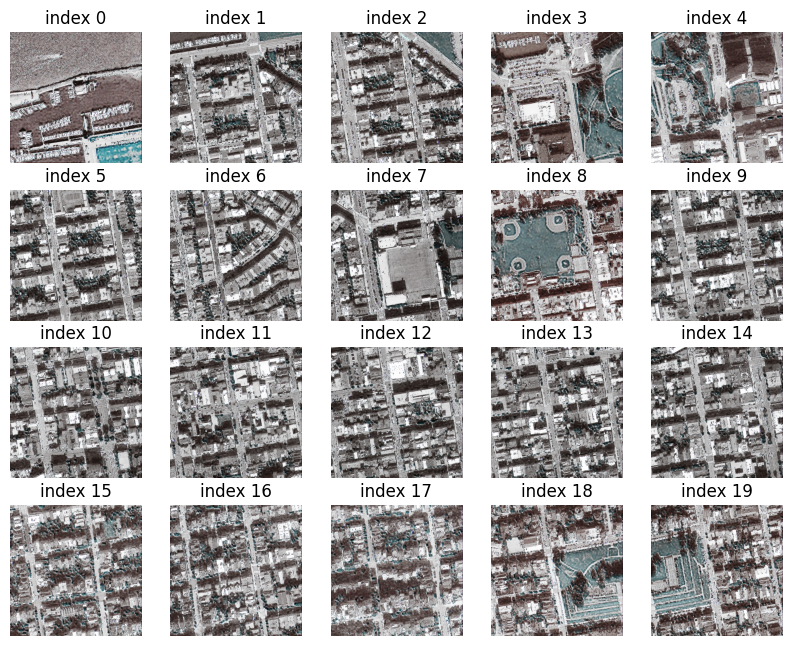

In [12]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2

# path = '/Data2/ZiHanCao/exps/panformer/visualized_img/data_hpmnet_wv3_ref'
const = 2047.
files = glob.glob(path+'/*.mat')
files = sorted(files, key=lambda x: int(x.split('_')[-1].strip('.mat')))
print(files)
print(f'find files in {path}')
f_len = len(files)
fig, axes = plt.subplots(ncols=np.ceil(f_len/4).astype('int'), nrows=4, figsize=(2*f_len//4, 2*4), dpi=100)
axes = axes.flatten()
for i, f in enumerate(files):
    sr = io.loadmat(f).get('sr') / const
    sr=sr.clip(0, 1)
    show_sr = (sr[..., :3]*255).astype('uint8')
    for j in range(3):
        show_sr[..., j] = cv2.equalizeHist(show_sr[..., j])
    axes[i].imshow(show_sr)
    axes[i].set_axis_off()
    axes[i].set_title(f'index {i}')
    
    if i == 0:
        print(f'shape as {sr.shape}')
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch



In [9]:
attn_feature = torch.load('./attn_and_feature.pth')
attns = [attn_feature['AttnFuse.forward'][0][0], *[attn_feature['MSReversibleRefine.forward'][i][0] for i in range(5)]]
feats = [attn_feature['AttnFuse.forward'][0][1], *[attn_feature['MSReversibleRefine.forward'][i][1] for i in range(5)]]

In [19]:
attn_f = torch.stack(attns).flatten(1)
feat_f = torch.stack(feats).flatten(1)
sm_attn = (attn_f @ attn_f.t()).softmax(-1)
sm_feat = (feat_f @ feat_f.t()).so
# plt.imshow(sm)
sm

tensor([[5.0000e-01, 5.0000e-01, 2.6649e-25, 2.6193e-25, 7.7893e-26, 3.2164e-25],
        [5.0000e-01, 5.0000e-01, 2.6649e-25, 2.6193e-25, 7.7893e-26, 3.2164e-25],
        [9.4034e-02, 9.4034e-02, 2.5240e-01, 1.9772e-01, 1.5869e-01, 2.0312e-01],
        [1.0884e-01, 1.0884e-01, 2.3283e-01, 2.0274e-01, 1.4413e-01, 2.0262e-01],
        [3.5064e-02, 3.5064e-02, 2.0244e-01, 1.5615e-01, 4.3119e-01, 1.4009e-01],
        [1.2555e-01, 1.2555e-01, 2.2470e-01, 1.9034e-01, 1.2148e-01, 2.1238e-01]])

In [ ]:
import PIL.Image as Image

Image.open('/Data3/cao/ZiHanCao/datasets/VIF-MSRS/train/Segmentation_labels/00187D.png')

In [ ]:
###

[0.34971435 0.29871345 0.29522871 0.37733907 0.321758   0.37650082
 0.37979986]
[0.20507095 0.22632677 0.22603483 0.20735183 0.22743252 0.20648748
 0.18418333]
[0.26489642 0.2278138  0.24649272 0.24556653 0.23923585 0.24739234
 0.26093955]
[0.18031828 0.24714598 0.23224374 0.16974257 0.21157364 0.16961935
 0.17507726]


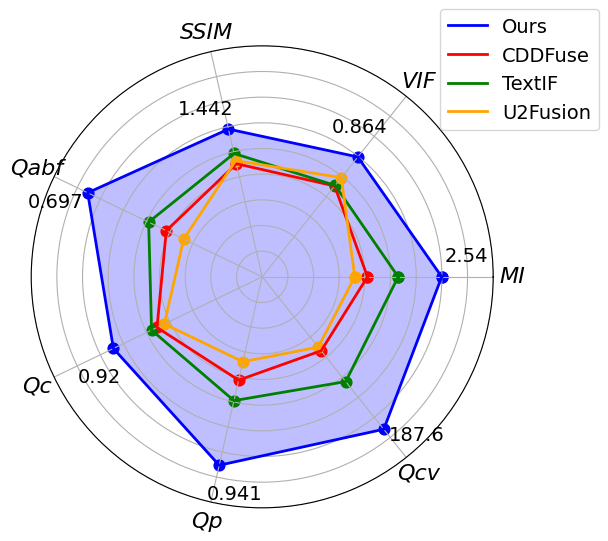

In [86]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
                
# 创建图表
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# 数据准备
labels = np.array(['MI', 'VIF', 'SSIM', 'Qabf', 'Qc', 'Qp', 'Qcv'])
num_vars = len(labels)

# 角度计算
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 闭合


# 需要绘制的数据值
values_ours_ = np.array([2.54, 0.8644, 1.4423, 0.6971, 0.9197, 0.9406, 187.6])
values_ours = np.array([2.34, 0.8144, 1.4023, 0.5971, 0.8301, 0.9406, 1/200.6])
values_TextIF = np.array([2.0902, 0.7466, 1.3274, 0.5256, 0.8157, 0.9293, 1/354.5596])
values_CDDFuse = np.array([2.21, 0.7482, 1.3517, 0.5458, 0.8178, 0.9327, 1/258.91])
values_U2Fusion = np.array([2.03, 0.7681, 1.335, 0.5017, 0.8127, 0.9256, 1/374.7083])

# normalize it
values_all = np.stack([values_ours, values_TextIF, values_CDDFuse, values_U2Fusion], axis=0)
values_all = values_all / values_all.max(axis=0, keepdims=True)
colors = ['blue', 'red', 'green', 'orange']
temps_for_each_metric = np.array([0.2, 0.3, 0.2, 0.2, 0.05, 0.02, 0.6])

def softmax_with_temp(values, temp=0.6):
    return sc.softmax(values / temp, axis=0)

values_all = softmax_with_temp(values_all, temps_for_each_metric)


def plot_radar(values, ax, fill=False, color='blue'):
    print(values)

    # 闭合数据环，起点和终点相同
    values = np.concatenate((values, [values[0]]))

    # 绘制雷达图
    if fill:
        ax.fill(angles, values, color=color, alpha=0.25)
    lin = ax.plot(angles, values, color=color, linewidth=2)

    # add dot of each datapoint
    ax.scatter(angles, values, color=color, s=60)

    return values, lin

lins = []
values_alls = []
for i in range(values_all.shape[0]):
    values, lin = plot_radar(values_all[i], ax, fill=False if i != 0 else True, color=colors[i])
    values_alls.append(values)
    lins.append(lin)
    
values_ours = values_alls[0]

# add text
for i, label in enumerate(labels):
    ax.text(angles[i]+0.1, values_ours[i] + 0.05, str(round(values_ours_[i], 3)), ha='center', va='center', fontsize=14)

# 添加标签
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])  # 去掉最后一个角度，不闭合标签
ax.set_ylim(0, 0.45)
# 斜体
ax.set_xticklabels(labels, fontsize=16, fontstyle='italic')  # 标签和角度数量一致

# add legend with line and shift to upper right
# add some shift 
ax.legend([l[0] for l in lins], ['Ours', 'CDDFuse', 'TextIF', 'U2Fusion'], loc='upper right', fontsize=14, frameon=True, bbox_to_anchor=(1.25, 1.1))

plt.show()


([<matplotlib.axis.YTick at 0x7fa71f185040>,
 [Text(0, 0.0, '0.7'), Text(0, 0.2, '0.728'), Text(0, 1.212, '0.853')])

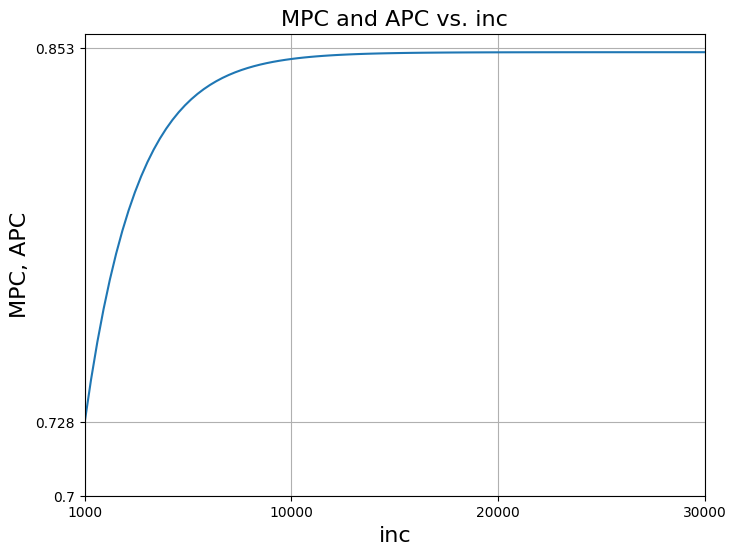

In [52]:
# plot exponetial curve
import numpy as np
import matplotlib.pyplot as plt

# 创建数据
x = np.linspace(0, 30, 100)
alpha = -0.4
intercept = 0.2
y = 1 - np.exp(alpha * x) + intercept

# 创建图表
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Exponential Curve')
plt.xlabel('inc', fontsize=16)
plt.ylabel('MPC, APC', fontsize=16)
plt.xlim(0, 30)
plt.title('MPC and APC vs. inc', fontsize=16)
# plt.legend()
plt.grid(True)

# set x tick label to from 0 to 30000
plt.xticks(np.linspace(0, 30, 4), labels=[1000, 10000, 20000, 30000])
plt.yticks([0, 0.2, 1.212], [0.7, 0.728, 0.853])

# arrows and txt
# plt.arrow(6, 1.0, -0.1, 0.1, head_width=0.2, head_length=0.1, fc='black', ec='black', length_includes_head=True)


# plt.show()



In [14]:
np.arange(0, 40, 4)

array([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36])

In [9]:
import torch
import torch.nn.functional as F
from torchvision.io import read_image
from einops import rearrange


def window_extract_2d(x: torch.Tensor, window_size: int):
    B, C, H, W = x.shape
    
    # NOTE: different from the window partition
    # nh = H // window_size
    # nw = W // window_size
    # x[..., ::nh, ::nw]
    x = rearrange(x, 'b c (p1 nh) (p2 nw) -> (b nh nw) c p1 p2', p1=window_size, p2=window_size)
    
    return x

def window_reverse_2d(windows: torch.Tensor, window_size: int, H: int, W: int):
    # windows: [B x nh x nw, c, p1, p2]
    
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    
    x = rearrange(windows, '(b nh nw) c p1 p2 -> b c (p1 nh) (p2 nw)', p1=window_size, p2=window_size, b=B, 
                  c=windows.shape[1], nh=H // window_size, nw=W // window_size)
    
    return x

device = 'cpu'

img = read_image('/Data3/cao/ZiHanCao/datasets/MEF-MEFB/OVER/AirBellowsGap.png')[None, ...].to(device) / 255.0
cond = read_image('/Data3/cao/ZiHanCao/datasets/MEF-MEFB/UNDER/AirBellowsGap.png')[None, ...].to(device) / 255.0

img_size = (768, 1024)
img = F.interpolate(img, img_size, mode='bilinear', align_corners=False)
cond = F.interpolate(cond, img_size, mode='bilinear', align_corners=False)

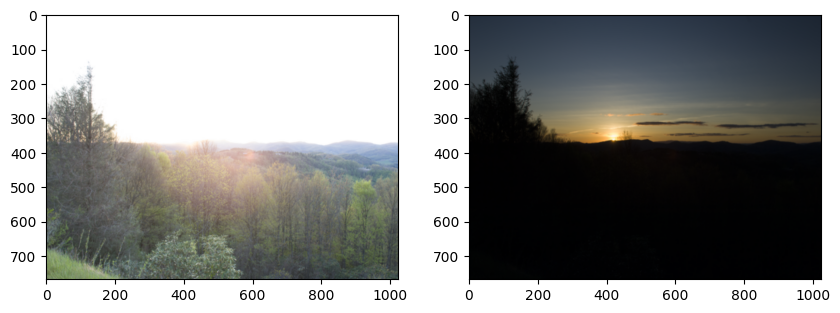

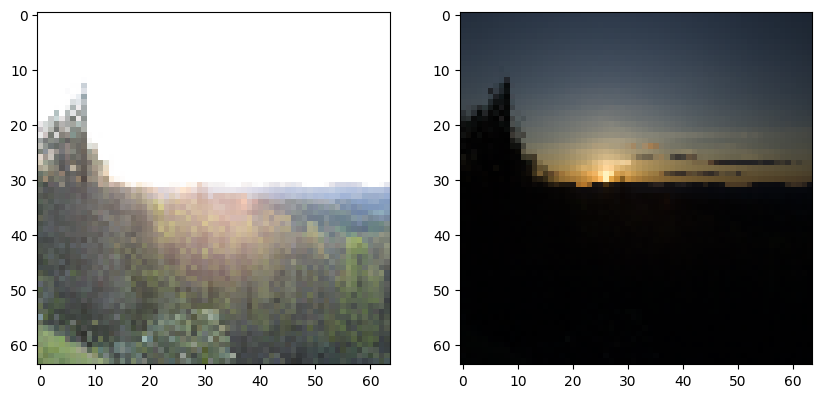

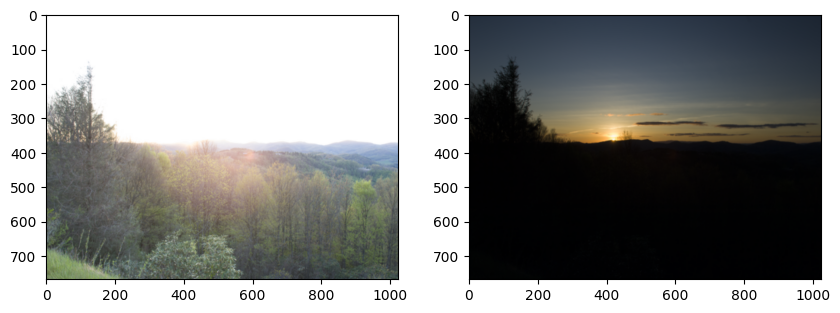

In [10]:
import matplotlib.pyplot as plt

# plot image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[0].permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(cond[0].permute(1, 2, 0))
plt.show()

# extract window
window_size = 64
img_windows = window_extract_2d(img, window_size)
cond_windows = window_extract_2d(cond, window_size)

# plot the first window
wind_idx = 0
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_windows[wind_idx].permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(cond_windows[wind_idx].permute(1, 2, 0))
plt.show()

# reverse the window
img_windows_rev = window_reverse_2d(img_windows, window_size, img_size[0], img_size[1])
cond_windows_rev = window_reverse_2d(cond_windows, window_size, img_size[0], img_size[1])
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_windows_rev[0].permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(cond_windows_rev[0].permute(1, 2, 0))

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


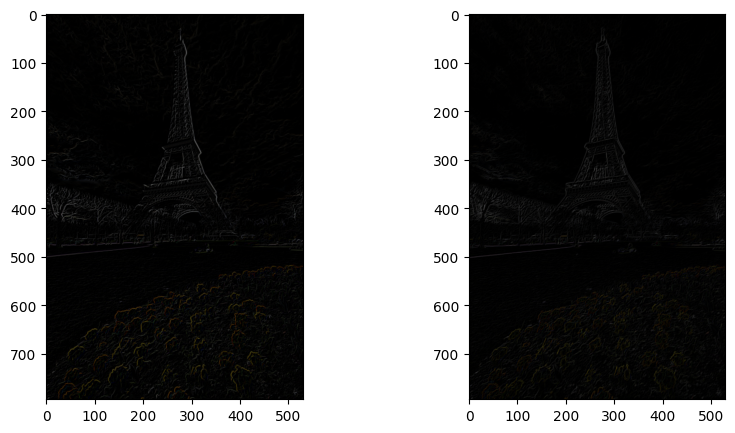

In [40]:
from kornia.filters import spatial_gradient
from kornia.io import load_image, ImageLoadType
import matplotlib.pyplot as plt

img = load_image('/Data3/cao/ZiHanCao/exps/IF-FILM-main/test_output/MEFB/recolored/tower.png', ImageLoadType.UNCHANGED)[None] / 255.

img_o1 = spatial_gradient(img, order=1, normalized=True).max(dim=2)[0]
img_o2 = spatial_gradient(img, order=2, normalized=True).max(dim=2)[0]

img_o1 = img_o1[0].detach().cpu().numpy().transpose(1, 2, 0)
img_o2 = img_o2[0].detach().cpu().numpy().transpose(1, 2, 0)

# norm
# img_o1 = (img_o1 - img_o1.min()) / (img_o1.max() - img_o1.min())
# img_o2 = (img_o2 - img_o2.min()) / (img_o2.max() - img_o2.min())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_o1)
plt.subplot(1, 2, 2)
plt.imshow(img_o2)
plt.show()


In [42]:
img_o1.max()


0.42107844

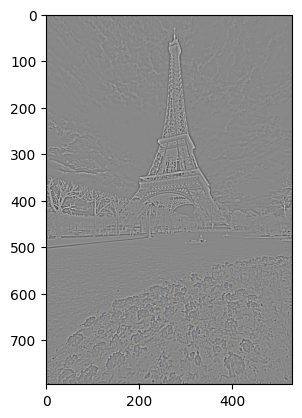

In [33]:
from kornia.filters import laplacian
from kornia.io import load_image, ImageLoadType
import matplotlib.pyplot as plt

img = load_image('/Data3/cao/ZiHanCao/exps/IF-FILM-main/test_output/MEFB/recolored/tower.png', ImageLoadType.UNCHANGED)[None] / 255.

img_o1 = laplacian(img, kernel_size=7)

# norm
img_o1 = (img_o1 - img_o1.min()) / (img_o1.max() - img_o1.min())

img_o1 = img_o1[0].detach().cpu().numpy().transpose(1, 2, 0)

plt.imshow(img_o1)



In [21]:
img_o1.shape

torch.Size([1, 3, 356, 536])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


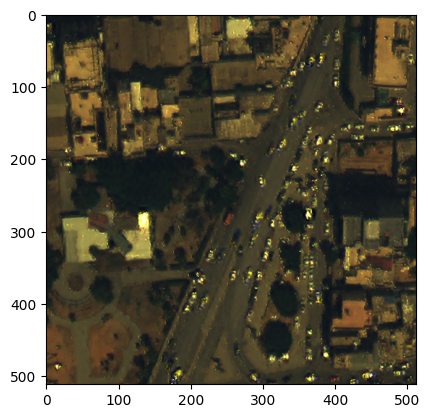

In [3]:
from scipy.io import loadmat

mat = loadmat('/Data3/cao/ZiHanCao/exps/panformer/visualized_img/RWKVFusion_v12_RWKVFusion/data_RWKVFusion_v12_RWKVFusion_wv3_unref_p64.mat')
sr = mat['sr']

# plot
import matplotlib.pyplot as plt
plt.imshow(sr[0, [4,2,0]].transpose(1, 2, 0) / 2027)
plt.show()

In [2]:
sr

array([[[[ 288.77298 ,  249.84138 ,  255.56735 , ...,  333.1217  ,
           343.93768 ,  339.852   ],
         [ 279.64658 ,  250.44183 ,  253.47392 , ...,  349.1848  ,
           294.23962 ,  319.17032 ],
         [ 275.80032 ,  257.394   ,  261.3875  , ...,  302.0458  ,
           294.0332  ,  318.68967 ],
         ...,
         [ 274.33676 ,  269.93558 ,  279.11594 , ...,  282.61194 ,
           276.79044 ,  265.39462 ],
         [ 285.91373 ,  281.93637 ,  295.6353  , ...,  239.91159 ,
           238.02408 ,  230.13483 ],
         [ 308.3146  ,  304.277   ,  307.88394 , ...,  211.3107  ,
           210.93462 ,  210.11497 ]],

        [[ 266.24408 ,  203.28537 ,  191.73941 , ...,  388.9596  ,
           497.13107 ,  412.1844  ],
         [ 243.04872 ,  205.12688 ,  209.17102 , ...,  466.3331  ,
           638.12    ,  638.0611  ],
         [ 300.86383 ,  242.45251 ,  241.47432 , ...,  302.6582  ,
           319.0893  ,  568.1976  ],
         ...,
         [ 290.3523  ,  279.2849  

In [13]:
from torchvision.io import read_image
device = 'cpu'


mask = read_image('/Data3/cao/ZiHanCao/datasets/VIF-MSRS/train/Segmentation_labels/00891N.png').to(device)


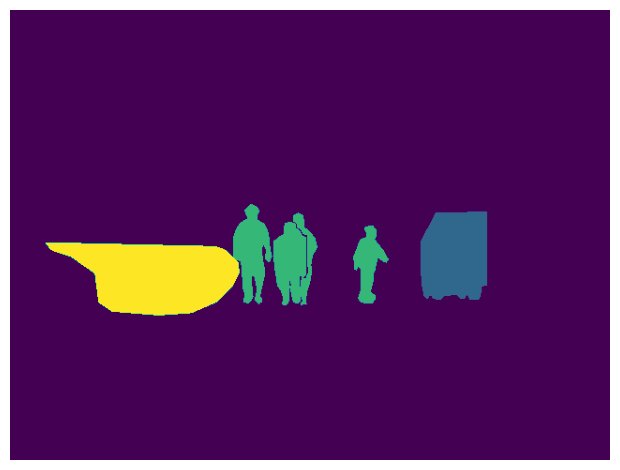

In [2]:
import matplotlib.pyplot as plt
plt.imshow(mask[0].cpu().numpy())
plt.axis('off')
plt.tight_layout()
plt.show()



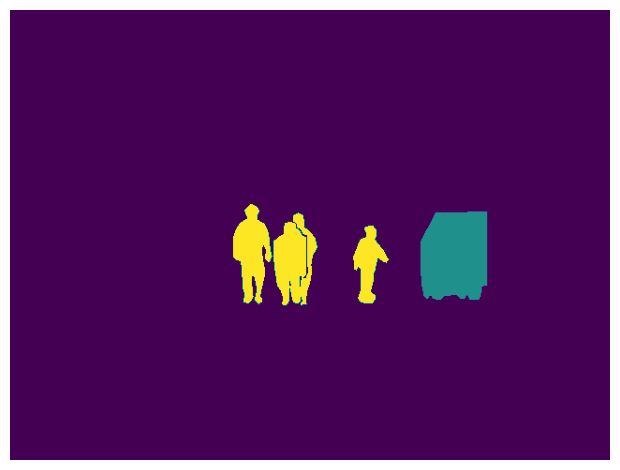

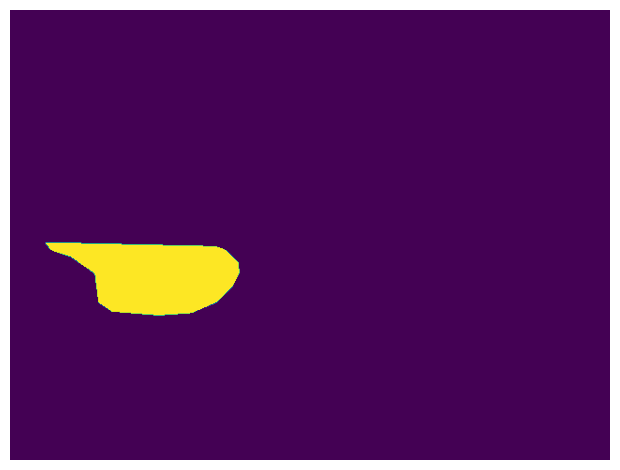

In [16]:
# 合并mask=1和mask=2
mask1 = mask.clone()
mask1[(mask1!=1) & (mask1!=2)] = 0
plt.imshow(mask1[0].cpu().numpy())
plt.axis('off')
plt.tight_layout()
plt.show()

# 显示mask=3
mask2 = mask.clone()
mask2[mask2!=3] = 0
plt.imshow(mask2[0].cpu().numpy())
plt.axis('off')
plt.tight_layout()
plt.show()



In [8]:
mask.unique()

tensor([0, 1], dtype=torch.uint8)